In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [36]:
# september 28 to october 26 2019
#weeks = [191005, 191012, 191019, 191026]
weeks = [190824, 190831, 190907, 190914, 190921]
# W 4 ST-WASH SQ

columns = ['c/a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 
           'time', 'desc', 'entries', 'exits']


In [37]:
def consolidator(weeks):
    
    dfs = []
    for week in weeks:
        link = f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week}.txt'
        dfs.append(pd.read_csv(link, parse_dates =[['date', 'time']], keep_date_col=True, names=columns, skiprows=1))
    df = pd.concat(dfs)
    
    # add date columns
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date_time'].dt.day_name()
    df['week'] = df['date_time'].dt.week
    # filter rows:
    df = df[(df['division'].isin(['BMT', 'IND', 'IRT']) 
         & df.time.astype(str).str.contains('00:00'))]

    # sort
    df.sort_values(['c/a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
    
    #dd
    df.drop_duplicates(subset=['c/a', 'unit', 'scp', 'station', 'date_time'], inplace=True)#.reset_index()
    ## groupby station to find prev_entries 
    df.reset_index(drop=True, inplace=True)
    df[['prev_date', 'prev_exits']] = (df.groupby(['c/a', 'unit', 'scp', 'station'])
                                           ['date', 'exits'].apply(lambda x: x.shift(-1)))
    
    # exits tally 
    df['out'] = df['exits'] - df['prev_exits']
    # drop first date nulls
    df.dropna(subset=['prev_exits'], axis=0, inplace=True)
    df = df[(df['out'] > 0) & (df['out'] < 100000)]
    return df

In [38]:
# exits per scp per hour
df = consolidator(weeks)

# exits by station per day
df_daily = df.groupby(['date', 'station'])['out'].sum().reset_index()

# exits by station per hour
df_hourly = df.groupby(['date_time', 'station'])['out'].sum().reset_index()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [39]:
# df for 59th st daily
mask59_d = (df_daily['station'] == '59 ST')

daily_59 = df_daily[mask59_d]

In [40]:
# df for 59th st hourly saturday to friday
mask59_h = (df_hourly['station'] == '59 ST')

hourly_59 = df_hourly[mask59_h]


In [41]:
# df for 1 week of 59th st hourly traffic
mask_59_hw = (df_hourly['station'] == '59 ST') & (df_hourly['date_time'] >= '2019-09-07 04:00:00') & (df_hourly['date_time'] <= '2019-09-14 00:00:00')
week_hourly_59 = df_hourly[mask_59_hw]


In [42]:
# df for 1 day of 59th st hourly traffic (monday september 9)
mask_59_monday = (df_hourly['station'] == '59 ST') & (df_hourly['date_time'] >= '2019-09-09 04:00:00') & (df_hourly['date_time'] <= '2019-9-10 00:00:00')
monday_59 = df_hourly[mask_59_monday]

mask_fm_monday = (df_hourly['station'] == 'FLUSHING-MAIN') & (df_hourly['date_time'] >= '2019-09-09 04:00:00') & (df_hourly['date_time'] <= '2019-09-10 00:00:00')
monday_fm = df_hourly[mask_fm_monday]


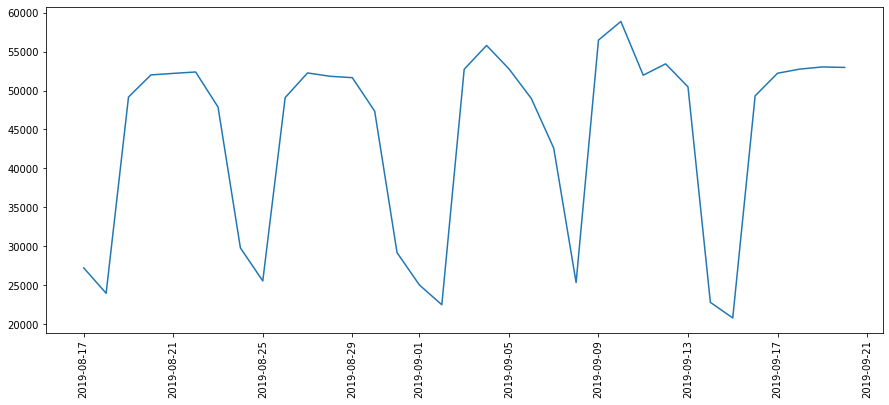

In [43]:
# Plot for daily 59th st traffic
plt.figure(figsize = [15,6])
plt.xticks(rotation=90)
plt.plot(daily_59['date'], daily_59['out']);


''

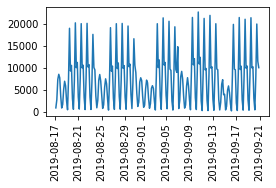

In [44]:
# Plot for hourly 59th st traffic

plt.figure(figsize = [4,2])
plt.plot(hourly_59['date_time'], hourly_59['out'])
plt.xticks(rotation='vertical')
;

''

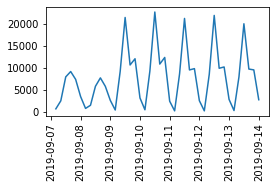

In [45]:
# plot for 1 week hourly traffic at 59th st

plt.figure(figsize = [4,2])
plt.plot(week_hourly_59['date_time'], week_hourly_59['out'])
plt.xticks(rotation='vertical')
;

''

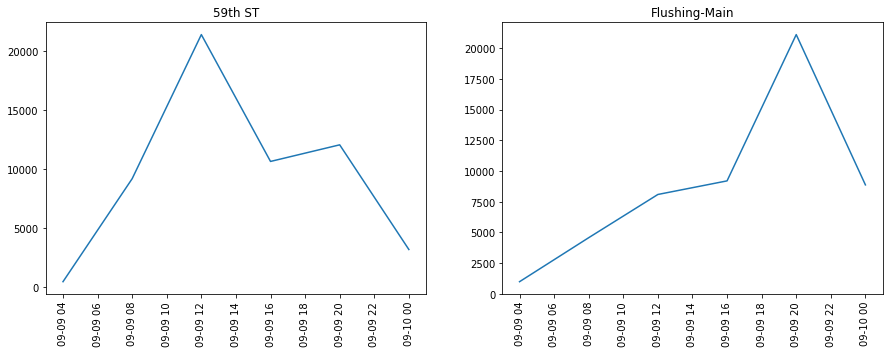

In [46]:
# plot for 1 day traffic 59th st & Flushing-Main (monday sept 30)   (notice swap in rush hour traffic )
plt.figure(figsize = [15,5])

plt.subplot(1,2,1)
plt.plot(monday_59['date_time'], monday_59['out'])
plt.title('59th ST')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.plot(monday_fm['date_time'], monday_fm['out'])
plt.title('Flushing-Main')
plt.xticks(rotation='vertical')
;

In [47]:
# loop / fxn for multiple plots?
stations = ['59 ST', 'FLUSHING-MAIN']

In [48]:
flushingmask = df

''

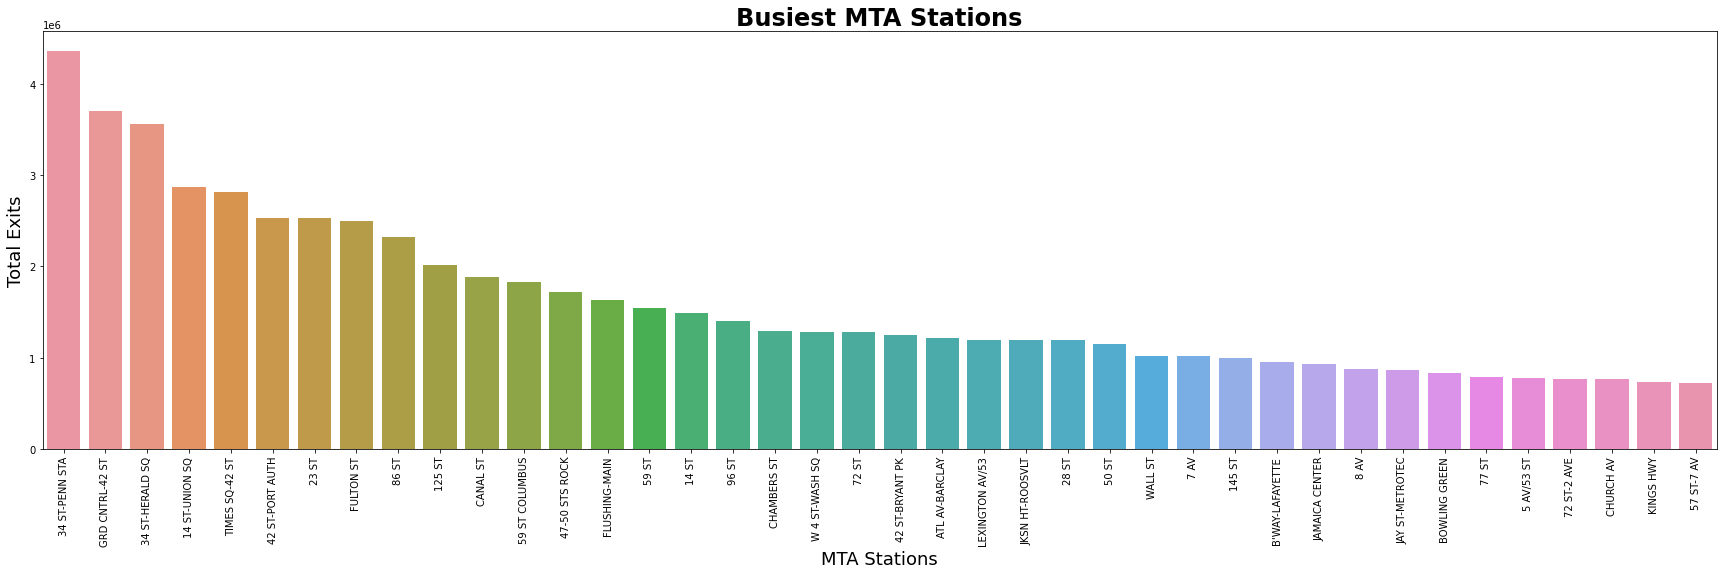

In [49]:
# setting as_index to false prevents station names from becoming index and allows to remain as column 
# df_daily = df.groupby(['station','date', 'week', 'day_of_week']).sum().reset_index()
plt.figure(figsize=(30,10))
df_station_total2 = df.groupby('station', as_index=False).out.sum()
top_station_mask = df_station_total2["out"]>700000
top_stations = df_station_total2[top_station_mask]
top_stations = top_stations.sort_values(['out'], ascending=False)

top_stations_chart = sns.barplot(x='station', y='out', data=top_stations.reset_index())
top_stations_chart.set_xticklabels(top_stations_chart.get_xticklabels(), rotation=90)
plt.xlabel('MTA Stations', fontsize=18)
plt.ylabel('Total Exits', fontsize=18)
plt.title("Busiest MTA Stations", fontsize=24, weight='bold')
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('top_stations_by_out')
;


''

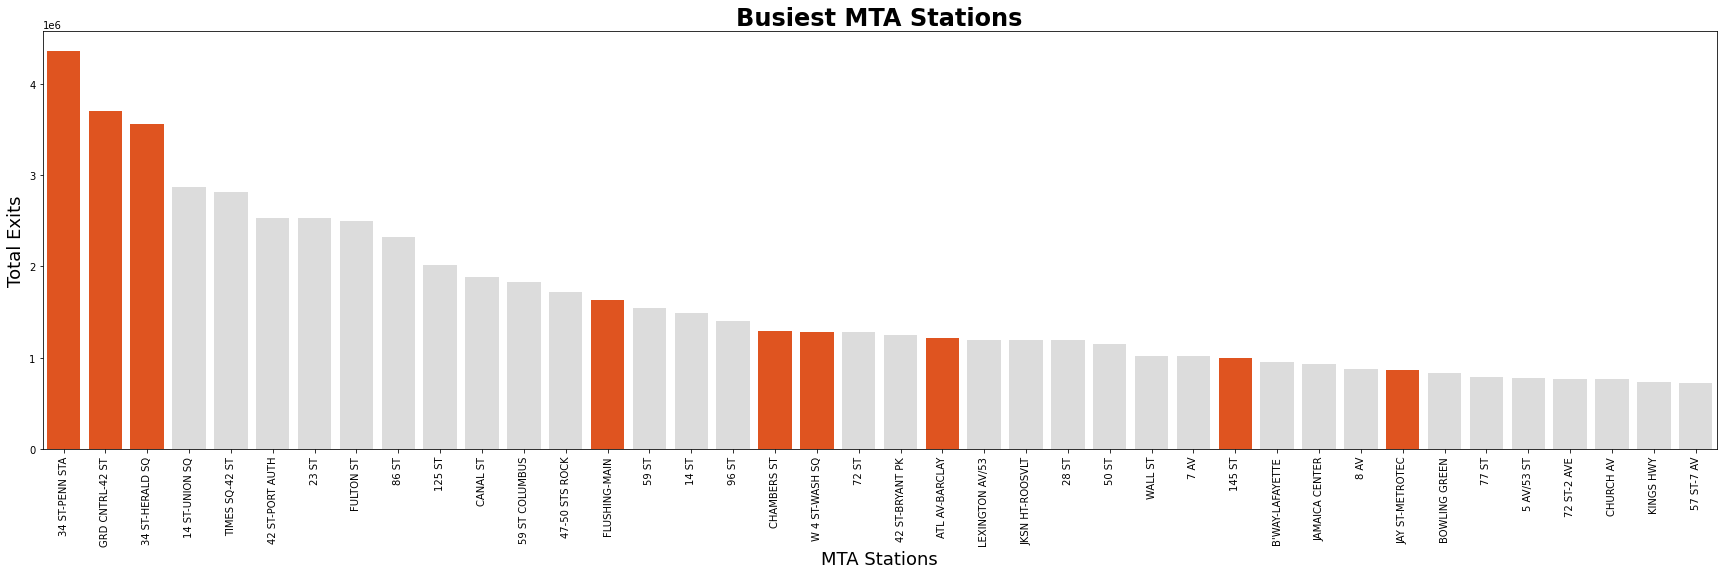

In [50]:
stat = ['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', 'W 4 ST-WASH SQ', 'CHAMBERS ST', '145 ST', 'FLUSHING-MAIN', 'ATL AV-BARCLAY', 'JAY ST-METROTEC']

plt.figure(figsize=(30,10))
df_station_total2 = df.groupby('station', as_index=False).out.sum()
top_station_mask = df_station_total2["out"]>700000
top_stations = df_station_total2[top_station_mask]
top_stations = top_stations.sort_values(['out'], ascending=False)

top_stations_chart = sns.barplot(x='station', y='out', data=top_stations.reset_index(), palette=['orangered' if x in stat else 'gainsboro' for x in top_stations['station']])
top_stations_chart.set_xticklabels(top_stations_chart.get_xticklabels(), rotation=90)
#top_stations_chart.set_color('r')
sns.set_color_codes('muted')
plt.xlabel('MTA Stations', fontsize=18)
plt.ylabel('Total Exits', fontsize=18)
plt.title("Busiest MTA Stations", fontsize=24, weight='bold')
plt.gcf().subplots_adjust(bottom=0.30)

plt.savefig('top_stations_by_out_highlight')
;

In [51]:
 '34 ST-PENN STA' or x == 'GRD CNTRL-42 ST' 

'34 ST-PENN STA'

In [52]:
#initial breakdown of stations to target before final target list 
df_station_total2[top_station_mask].sort_values(by='out',ascending=False)

,station,out
58,34 ST-PENN STA,4359604.0
226,GRD CNTRL-42 ST,3707181.0
56,34 ST-HERALD SQ,3562879.0
14,14 ST-UNION SQ,2874787.0
329,TIMES SQ-42 ST,2813084.0
65,42 ST-PORT AUTH,2536614.0
43,23 ST,2530408.0
219,FULTON ST,2499681.0
107,86 ST,2324764.0
9,125 ST,2019948.0


''

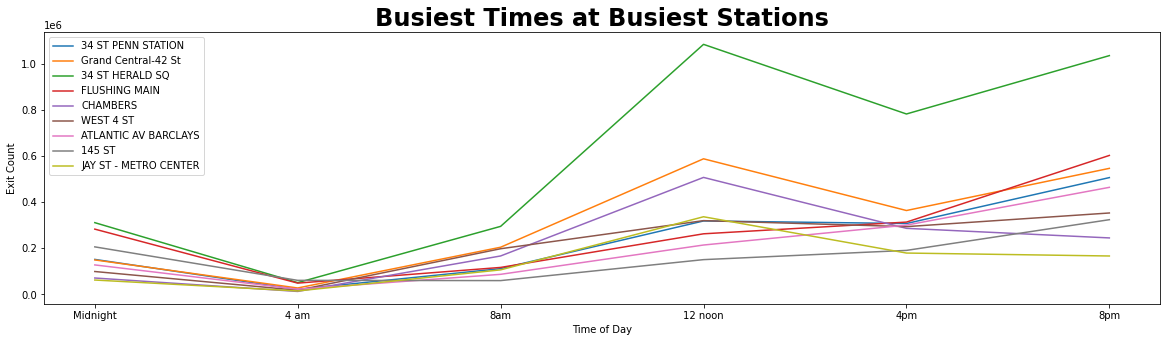

In [53]:
# create a mask to filter one particular station 
station_mask_34_PENN = df['unit']=='R012'
# apply mask, creates new DF consisting of data for a single station 
station_34_PENN = df[station_mask_34_PENN]
#
station_34_PENN_time_list = list(station_34_PENN.groupby(['time']).out.sum())
station_34_PENN_time_list

# create a mask to filter one particular station 
station_mask_GRD_CNTRL_42 = df['unit']=='R046'
# apply mask, creates new DF consisting of data for a single station 
station_GRD_CNTRL_42 = df[station_mask_GRD_CNTRL_42]
#
station_GRD_CNTRL_42_time_list = list(station_GRD_CNTRL_42.groupby(['time']).out.sum())
station_GRD_CNTRL_42_time_list

# create a mask to filter one particular station 
station_mask_34_HERALD = df['station']=='34 ST-HERALD SQ'
# apply mask, creates new DF consisting of data for a single station 
station_34_HERALD = df[station_mask_34_HERALD]
#
station_34_HERALD_time_list = list(station_34_HERALD.groupby(['time']).out.sum())
station_34_HERALD_time_list

# create a mask to filter one particular station 
station_mask_FLUSHING_MAIN = df['station']=='FLUSHING-MAIN'
# apply mask, creates new DF consisting of data for a single station 
station_FLUSHING_MAIN = df[station_mask_FLUSHING_MAIN]
#
station_FLUSHING_MAIN_time_list = list(station_FLUSHING_MAIN.groupby(['time']).out.sum())
station_FLUSHING_MAIN_time_list

# create a mask to filter one particular station 
station_mask_ATL_BARCLAY = df['station']=='ATL AV-BARCLAY'
# apply mask, creates new DF consisting of data for a single station 
station_ATL_BARCLAY = df[station_mask_ATL_BARCLAY]
#
station_ATL_BARCLAY_time_list = list(station_ATL_BARCLAY.groupby(['time']).out.sum())
station_ATL_BARCLAY_time_list

# create a mask to filter one particular station 
station_mask_JAY_METRO = df['station']=='JAY ST-METROTEC'
# apply mask, creates new DF consisting of data for a single station 
station_JAY_METRO = df[station_mask_JAY_METRO]
#
station_JAY_METRO_time_list = list(station_JAY_METRO.groupby(['time']).out.sum())
station_JAY_METRO_time_list


# create a mask to filter one particular station 
station_mask_W_4ST = df['station']=="W 4 ST-WASH SQ"
# apply mask, creates new DF consisting of data for a single station 
station_W_4ST = df[station_mask_W_4ST]
#
station_W_4ST_time_list = list(station_W_4ST.groupby(['time']).out.sum())
station_W_4ST_time_list


# create a mask to filter one particular station 
station_mask_CHAMBERS = df['station']=='CHAMBERS ST'
# apply mask, creates new DF consisting of data for a single station 
station_CHAMBERS = df[station_mask_CHAMBERS]
#
station_CHAMBERS_time_list = list(station_CHAMBERS.groupby(['time']).out.sum())
station_CHAMBERS_time_list


# create a mask to filter one particular station 
station_mask_145 = df['station']=='145 ST'
# apply mask, creates new DF consisting of data for a single station 
station_145 = df[station_mask_145]
#
station_145_time_list = list(station_145.groupby(['time']).out.sum())
station_145_time_list




plt.figure(figsize=(20,5))
plt.plot(station_34_PENN_time_list)
plt.plot(station_GRD_CNTRL_42_time_list)
plt.plot(station_34_HERALD_time_list)
plt.plot(station_FLUSHING_MAIN_time_list)
plt.plot(station_CHAMBERS_time_list)
plt.plot(station_W_4ST_time_list)
plt.plot(station_ATL_BARCLAY_time_list)
plt.plot(station_145_time_list)
plt.plot(station_JAY_METRO_time_list)


plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['34 ST PENN STATION', 'Grand Central-42 St', '34 ST HERALD SQ', 'FLUSHING MAIN', 'CHAMBERS', 'WEST 4 ST', 'ATLANTIC AV BARCLAYS', '145 ST','JAY ST - METRO CENTER'])
plt.title("Busiest Times at Busiest Stations", fontsize=24, weight='bold')



plt.savefig('nine_featured_stations_by_time')

;

''

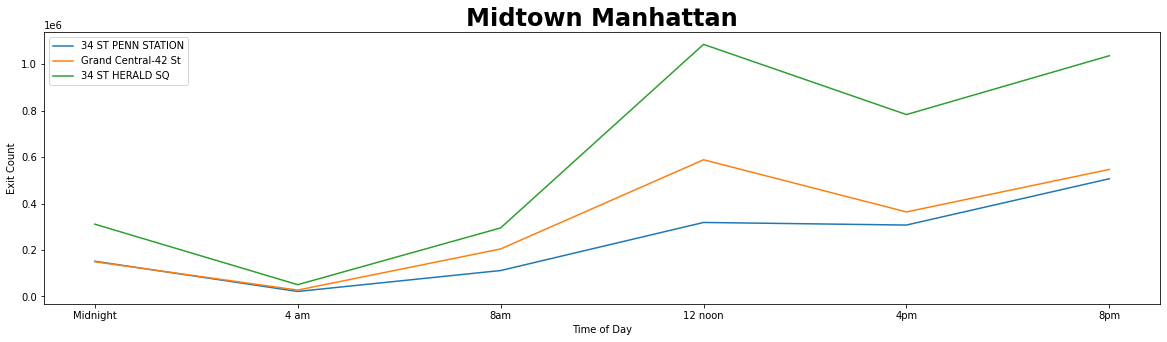

In [54]:
# MIDTOWN

plt.figure(figsize=(20,5))
plt.plot(station_34_PENN_time_list)
plt.plot(station_GRD_CNTRL_42_time_list)
plt.plot(station_34_HERALD_time_list)

plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['34 ST PENN STATION', 'Grand Central-42 St', '34 ST HERALD SQ'])
plt.title("Midtown Manhattan", fontsize=24, weight='bold')

plt.savefig('midtown_manhattan')

;

''

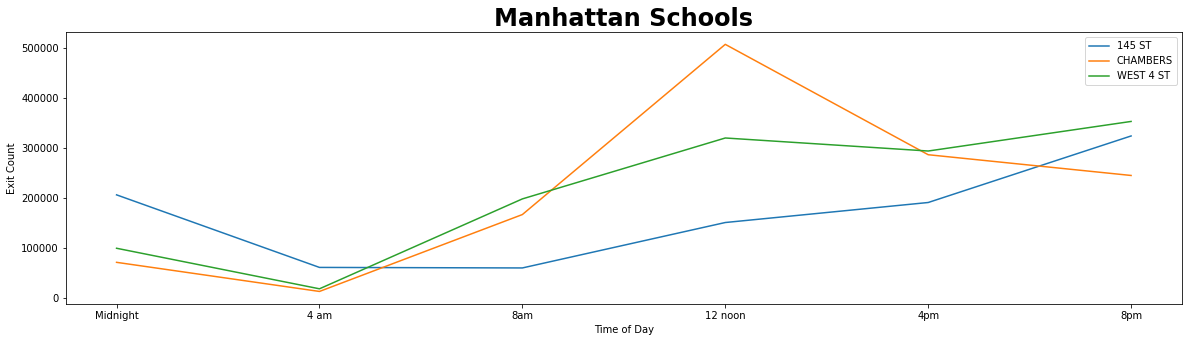

In [55]:
# MANHATTAN SCHOOLS 

plt.figure(figsize=(20,5))

plt.plot(station_145_time_list)
plt.plot(station_CHAMBERS_time_list)
plt.plot(station_W_4ST_time_list)

plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['145 ST', 'CHAMBERS', 'WEST 4 ST',])
plt.title("Manhattan Schools", fontsize=24, weight='bold')


plt.savefig('manhattan_schools')

;

''

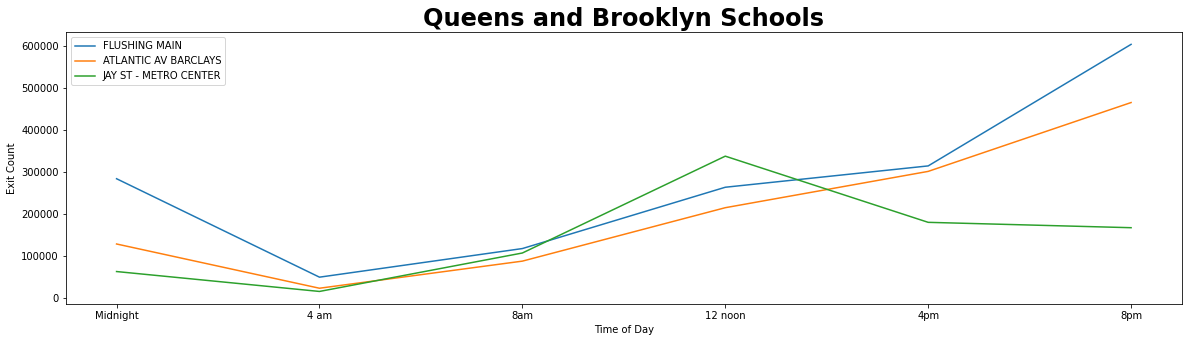

In [56]:
# QUEENS AND BROOKLYN SCHOOLS 

plt.figure(figsize=(20,5))
plt.plot(station_FLUSHING_MAIN_time_list)
plt.plot(station_ATL_BARCLAY_time_list)
plt.plot(station_JAY_METRO_time_list)

plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['FLUSHING MAIN', 'ATLANTIC AV BARCLAYS', 'JAY ST - METRO CENTER'])
plt.title("Queens and Brooklyn Schools", fontsize=24, weight='bold')

plt.savefig('queens_brooklyn_schools')

;